In [127]:
import json
import os
import pandas
import pyarrow
import sys

from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')

In [128]:
sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
import create_queries
import prepare_data
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
COMPANY_IDENTIFIER = 'ML'
TRANSFER_PACKAGES_START_DATE = '2020-01-01'
SALES_TRANSACTIONS_START_DATE = '2020-01-01'

In [135]:
# company_licenses_query = create_queries.create_company_licenses_query(COMPANY_IDENTIFIER)
company_download_summaries_query = create_queries.create_download_summaries_query(COMPANY_IDENTIFIER, TRANSFER_PACKAGES_START_DATE)
company_sales_receipts_query = create_queries.create_company_sales_receipts_query(COMPANY_IDENTIFIER, SALES_TRANSACTIONS_START_DATE)
company_sales_receipts_with_transactions_query = create_queries.create_company_sales_receipts_with_transactions_query(COMPANY_IDENTIFIER, SALES_TRANSACTIONS_START_DATE)

engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

# company_licenses_dataframe = pandas.read_sql_query(company_licenses_query, engine)
company_download_summaries_dataframe = pandas.read_sql_query(company_download_summaries_query, engine)
company_sales_receipts_dataframe = pandas.read_sql_query(company_sales_receipts_query, engine)
company_sales_receipts_with_transactions_dataframe = pandas.read_sql_query(company_sales_receipts_with_transactions_query, engine)

## Licenses

## Download summaries

In [136]:
company_download_summaries_dataframe

,license_number,date,status
0,C9-0000300-LIC,2021-10-19,completed
1,C9-0000300-LIC,2021-10-18,completed
2,C9-0000300-LIC,2021-10-17,completed
3,C9-0000300-LIC,2021-10-16,completed
4,C9-0000300-LIC,2021-10-15,completed
...,...,...,...
653,C9-0000300-LIC,2020-01-05,completed
654,C9-0000300-LIC,2020-01-04,completed
655,C9-0000300-LIC,2020-01-03,completed
656,C9-0000300-LIC,2020-01-02,completed


In [144]:
license_numbers = company_download_summaries_dataframe['license_number'].unique()
download_summary_records = company_download_summaries_dataframe.to_dict('records')

license_number_to_download_summary_records = {}

for license_number in license_numbers:
    license_number_to_download_summary_records[license_number] = filter(
        lambda download_summary_record: download_summary_record['license_number'] == license_number,
        download_summary_records
    )

for license_number, download_summary_records in license_number_to_download_summary_records.items():
    print(f'Verifying download summaries for license {license_number}...')
    for download_summary_record in download_summary_records:
        if download_summary_record['status'] != 'completed':
            print(f'Found bad download summary for license {license_number} on date {download_summary_record.date}')

Verifying download summaries for license C9-0000300-LIC...


## Sales GMV month-over-month from metrc_sales_receipts

In [119]:
fn = lambda row: f'{row.sales_datetime.year}-{"0" if row.sales_datetime.month < 10 else ""}{row.sales_datetime.month}'
col = company_sales_receipts_dataframe.apply(fn, axis=1)
company_sales_receipts_dataframe = company_sales_receipts_dataframe.assign(sales_month=col.values)

<AxesSubplot:xlabel='sales_month'>

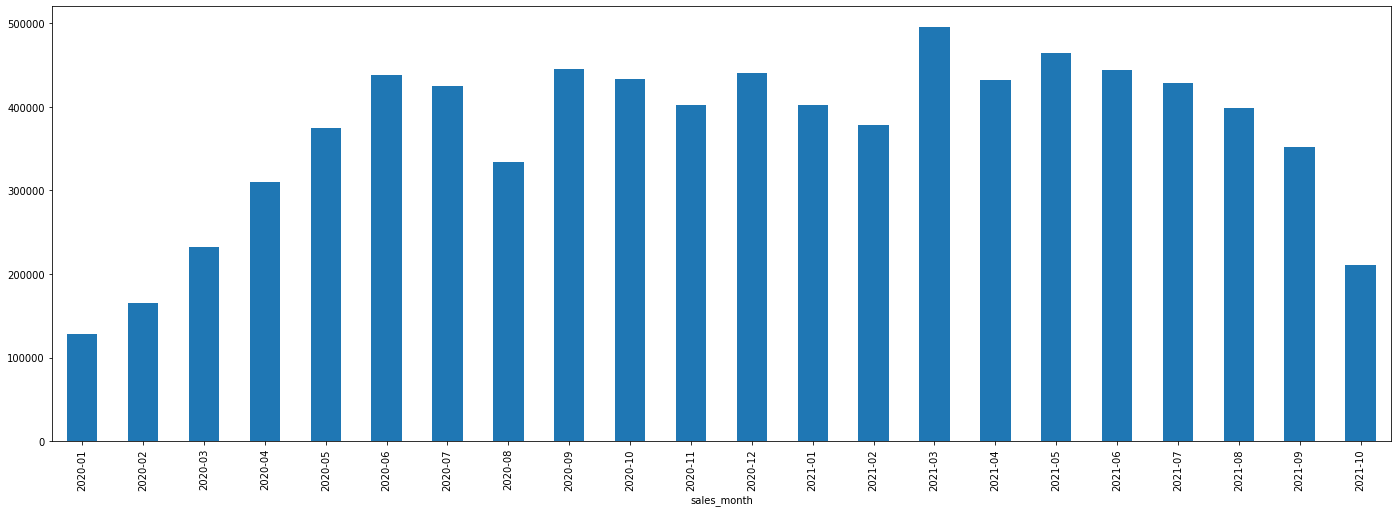

In [120]:
company_sales_receipts_dataframe.groupby(['sales_month'])['total_price'].sum().plot.bar(figsize=(24, 8), stacked=True)

## Sales GMV month-over-month from metrc_sales_transactions

In [121]:
deduped_sales_receipts_with_transactions_dataframe = prepare_data.dedupe_sales_transactions(company_sales_receipts_with_transactions_dataframe)

In [122]:
fn = lambda row: f'{row.sales_datetime.year}-{"0" if row.sales_datetime.month < 10 else ""}{row.sales_datetime.month}'
col = deduped_sales_receipts_with_transactions_dataframe.apply(fn, axis=1)
deduped_sales_receipts_with_transactions_dataframe = deduped_sales_receipts_with_transactions_dataframe.assign(sales_month=col.values)

<AxesSubplot:xlabel='sales_month'>

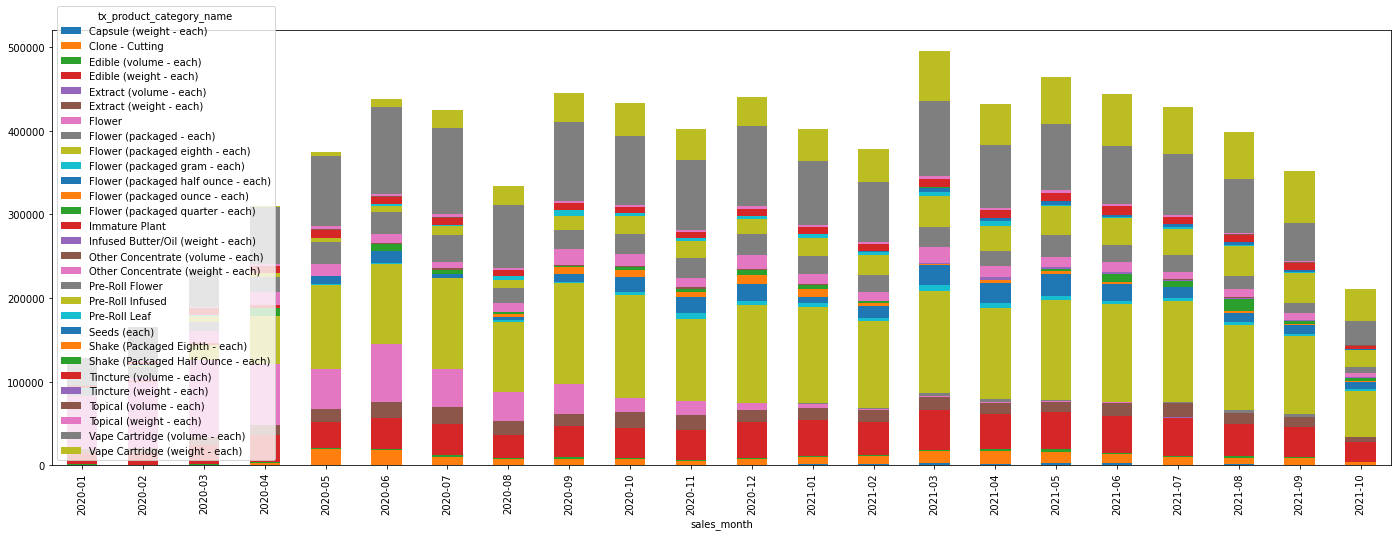

In [123]:
# Sales GMV month-over-month by product category name
deduped_sales_receipts_with_transactions_dataframe.groupby(['sales_month', 'tx_product_category_name'])['tx_total_price'].sum().unstack().plot.bar(figsize=(24, 8), stacked=True)

## Search for missing metrc_sales_transactions

In [124]:
sales_receipt_with_transactions_records = deduped_sales_receipts_with_transactions_dataframe.to_dict('records')

receipt_number_to_transactions = {}
for sales_receipt_with_transaction_record in sales_receipt_with_transactions_records:
    receipt_number = sales_receipt_with_transaction_record['receipt_number']
    if receipt_number in receipt_number_to_transactions:
        receipt_number_to_transactions[receipt_number] += [sales_receipt_with_transaction_record]
    else:
        receipt_number_to_transactions[receipt_number] = [sales_receipt_with_transaction_record]

In [125]:
import math

def float_eq(receipt_total_price: float, transactions_total_price: float, num_transactions: int) -> bool:
    # For every additional transaction, increase threshold by 0.01 (a penny).
    threshold = num_transactions * 0.1
    return math.isclose(receipt_total_price, transactions_total_price, abs_tol=threshold)

mismatch_count = 0 # Count of receipts where receipt total price does not match transactions total price.
missing_count = 0 # Count of receipts with no transactions.
total_count = 0 # Count of receipts (including those missing transactions).

mismatch_over_count = 0
mismatch_under_count = 0

month_to_mismatch_count = {}
month_to_missing_count = {}

month_to_mismatch_over_count = {}
month_to_mismatch_under_count = {}

example_mismatch_over_receipts = []
example_mismatch_under_receipts = []

for receipt_number, receipt_transactions in list(receipt_number_to_transactions.items()):
    receipt_total_price = receipt_transactions[0]['rt_total_price']
    receipt_sales_month = receipt_transactions[0]['sales_month']
    total_count += 1

    if len(receipt_transactions) == 1 and receipt_transactions[0]['tx_id'] == None:
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    transactions_total_price = sum(receipt_transaction['tx_total_price'] for receipt_transaction in receipt_transactions)
    if not float_eq(receipt_total_price, transactions_total_price, len(receipt_transactions)):
        mismatch_count += 1
        if receipt_total_price < transactions_total_price:
            mismatch_over_count += 1
            example_mismatch_over_receipts += [(receipt_number, receipt_transactions)]
        else:
            mismatch_under_count += 1
            example_mismatch_under_receipts += [(receipt_number, receipt_transactions)]

        if receipt_sales_month not in month_to_mismatch_count:
            month_to_mismatch_count[receipt_sales_month] = 0
        month_to_mismatch_count[receipt_sales_month] += 1
        continue

print(f'# mismatch receipt vs transactions: {mismatch_count} ({mismatch_count / total_count * 100}%)')
print(f'# missing transactions: {missing_count} ({missing_count / total_count * 100}%)')
print(f'# total: {total_count}')

if mismatch_count:
    print(f'# mismatch receipt vs transactions (transactions over): {mismatch_over_count} ({mismatch_over_count / mismatch_count * 100}%)')
    print(f'# mismatch receipt vs transactions (transactions under): {mismatch_under_count} ({mismatch_under_count / mismatch_count * 100}%)')

# mismatch receipt vs transactions: 0 (0.0%)
# missing transactions: 0 (0.0%)
# total: 141375


In [126]:
for example_mismatch_over_receipt in example_mismatch_over_receipts[:10]:
    receipt_number, receipt_transactions = example_mismatch_over_receipt
    first_receipt_transaction = receipt_transactions[0]
    print(receipt_number)
#     print(receipt_number, first_receipt_transaction['rt_total_price'])
    for receipt_transaction in receipt_transactions:
        print(receipt_transaction)
#         print(receipt_transaction['tx_package_id'], receipt_transaction['tx_quantity_sold'], receipt_transaction['tx_total_price'])
    print('')